# 🧪 Synthetic CT Oncology Cohort

Generates multi-visit patient timelines, writes TXT reports and JSON sidecars, and exports a RECIST-style JSONL.

## 0) Imports

In [1]:
# Add synthrad module directory to path
from pathlib import Path
import sys
import shutil
import json

MODULE_DIR = Path("/Users/eri/synthetic_reports/src/synthrad")
assert (MODULE_DIR / "generator.py").exists(), f"Can't find generator.py in {MODULE_DIR}"
sys.path.insert(0, str(MODULE_DIR))

# Import and reload modules
from synthrad import generator as gen, lexicons, schema
import importlib
importlib.reload(gen)
importlib.reload(lexicons) 
importlib.reload(schema)

print("Loaded modules from:", MODULE_DIR)

Loaded modules from: /Users/eri/synthetic_reports/src/synthrad


## 1) Cohort Parameters

In [2]:
# ---- cohort knobs ----
N_PATIENTS            = 8          # number of patients to synthesize
SEED                  = 42         # deterministic
STUDIES_PER_PATIENT   = 5          # max studies per patient (2–10 per your code)
FORCE_LOBE            = None       # choose from: None, "RUL","RML","RLL","LUL","LLL"

# Stage distribution (I/II/III/IV) — will be normalized by your parser
STAGE_DIST_STR        = "I:0.25,II:0.25,III:0.30,IV:0.20"

# Response distribution for follow-ups — normalized internally
RESPONSE_DIST_STR     = "CR:0.1,PR:0.3,SD:0.4,PD:0.2"

# Output directory (feel free to change)
OUT_DIR               = Path("./out_synthrad")
if OUT_DIR.exists():
    print("Cleaning existing output dir…")
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config OK")

Cleaning existing output dir…
Config OK


## 2) Generate the Cohort (multi-visit timelines)

In [3]:
rng = gen.random.Random(SEED)
stage_dist     = gen.parse_stage_dist(STAGE_DIST_STR)
response_dist  = gen.parse_response_dist(RESPONSE_DIST_STR)

all_cases = []
all_dates = []

for i in range(N_PATIENTS):
    patient_id = f"P{i:04d}"
    try:
        cases, study_dates = gen.generate_patient_timeline(
            patient_id=patient_id,
            seed=rng.randint(0, 10_000_000),
            stage_dist=stage_dist,
            lobe=FORCE_LOBE,
            max_studies=STUDIES_PER_PATIENT,
            response_dist=response_dist
        )
        # Write each study (TXT report + JSON sidecar + anatomic mapping)
        for c in cases:
            gen.write_case(c, str(OUT_DIR), c.meta.accession_number, use_radlex=True)
        all_cases.extend(cases)
        all_dates.extend(study_dates)
    except ZeroDivisionError:
        print(f"Warning: Skipping patient {patient_id} due to zero SLD in baseline scan")
        continue

print(f"Created {len(all_cases)} studies across {len(set(c.meta.patient_id for c in all_cases))} patients → {OUT_DIR.resolve()}")

Created 38 studies across 8 patients → /Users/eri/synthetic_reports/notebooks/out_synthrad


## 3) Peek at the Folder Structure

In [4]:
def tree(path: Path, depth=3, prefix=""):
    if depth < 0: 
        return
    files = sorted(path.iterdir(), key=lambda p:(p.is_file(), p.name))
    for p in files:
        print(prefix + ("📄 " if p.is_file() else "📁 ") + p.name)
        if p.is_dir():
            tree(p, depth-1, prefix + "    ")

tree(OUT_DIR, depth=4)

📁 P0000
    📁 study_01
        📄 20201001743186.json
        📄 20201001743186.txt
    📁 study_02
        📄 20200908797803.json
        📄 20200908797803.txt
    📁 study_03
        📄 20251204931410.json
        📄 20251204931410.txt
    📁 study_04
        📄 20250305607114.json
        📄 20250305607114.txt
    📁 study_05
        📄 20220914542280.json
        📄 20220914542280.txt
    📁 study_06
        📄 20220801936752.json
        📄 20220801936752.txt
📁 P0001
    📁 study_01
        📄 20210120999425.json
        📄 20210120999425.txt
    📁 study_02
        📄 20241023981737.json
        📄 20241023981737.txt
    📁 study_03
        📄 20241121340002.json
        📄 20241121340002.txt
📁 P0002
    📁 study_01
        📄 20250522351155.json
        📄 20250522351155.txt
    📁 study_02
        📄 20230218760289.json
        📄 20230218760289.txt
    📁 study_03
        📄 20241201880713.json
        📄 20241201880713.txt
    📁 study_04
        📄 20231016723092.json
        📄 20231016723092.txt
    📁 study_05

## 4) Load & Display a Sample Report + JSON

In [5]:
# grab one patient/study deterministically
some_patient_dir = sorted([p for p in OUT_DIR.iterdir() if p.is_dir()])[0]
some_study_dir   = sorted(some_patient_dir.iterdir())[0]   # study_01
sample_files     = sorted(some_study_dir.glob("*.txt"))
assert sample_files, "No TXT reports found"
sample_txt       = sample_files[0]
sample_json      = sample_txt.with_suffix(".json")

print("TXT:", sample_txt)
print("JSON:", sample_json)

print("\n=== TXT REPORT ===\n")
print(Path(sample_txt).read_text())

print("\n=== JSON (truncated) ===\n")
j = json.loads(Path(sample_json).read_text())
print(json.dumps(j, indent=2)[:2000] + "\n... (truncated) ...")

TXT: out_synthrad/P0000/study_01/20201001743186.txt
JSON: out_synthrad/P0000/study_01/20201001743186.json

=== TXT REPORT ===

TECHNIQUE: CT chest, abdomen, and pelvis with IV contrast. Axial images with multiplanar reconstructions.
COMPARISON: None.

FINDINGS:
Lungs/Primary: There is a 14 mm right middle lobe pulmonary mass with adjacent volume loss. (baseline measurement).
Mediastinum/Lymph nodes:
  left lower paratracheal (4L) lymph node subcentimeter in short axis. (baseline measurement).
  Enlarged station 1R (1R) lymph node measuring 18 mm in short axis. (baseline measurement).
Pleura: No pleural effusion.
Abdomen/Pelvis:
  Liver homogeneous in attenuation without focal mass.
  No focal hepatic lesion.
  Spleen normal in size.
  Adrenal glands without nodules.
Bones: No aggressive osseous lesion.

IMPRESSION:
- Primary right middle lobe pulmonary neoplasm 14 mm with adjacent volume loss; baseline measurement.
- Nodal disease involving stations 1R.
- No definite distant metastases

## 5) Summary Table

In [6]:
import pandas as pd

rows = []
for patient_dir in sorted([p for p in OUT_DIR.iterdir() if p.is_dir()]):
    for study_dir in sorted([p for p in patient_dir.iterdir() if p.is_dir()]):
        for jf in study_dir.glob("*.json"):
            data = json.loads(jf.read_text())
            meta   = data["meta"]
            clin   = data["clinical_data"]
            tnm    = clin["tnm"]
            primary = clin["primary"]
            nodes   = clin["nodes"]
            mets    = clin["mets"]
            rows.append({
                "patient_id": meta["patient_id"],
                "visit": meta["visit_number"],
                "accession": meta["accession_number"],
                "comparison_date": meta.get("comparison_date"),
                "T": tnm["T"], "N": tnm["N"], "M": tnm["M"], "Stage": tnm["stage_group"],
                "primary_lobe": primary["lobe"] if primary else None,
                "primary_mm": primary["size_mm"] if primary else None,
                "num_nodes": len(nodes),
                "num_mets": len(mets),
            })

df = pd.DataFrame(rows).sort_values(["patient_id", "visit"])
df.head(10)

/Users/eri/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,patient_id,visit,accession,comparison_date,T,N,M,Stage,primary_lobe,primary_mm,num_nodes,num_mets
0,P0000,1,20201001743186,None,T1b,N0,M0,I,RML,14.0,2,0
1,P0000,2,20200908797803,2024-07-24,T1b,N0,M0,I,RML,13.0,2,0
2,P0000,3,20251204931410,2024-12-18,T1a,N0,M0,I,RML,6.0,1,0
3,P0000,4,20250305607114,2025-02-20,T1a,N0,M1b,IV,RML,7.0,1,1
4,P0000,5,20220914542280,2025-07-26,T1a,N1,M1b,IV,RML,8.0,3,1
5,P0000,6,20220801936752,2026-01-20,T1a,N1,M1b,IV,RML,8.0,3,1
6,P0001,1,20210120999425,None,T2b,N2,M0,III,RML,67.0,2,0
7,P0001,2,20241023981737,2024-01-28,T3,N2,M0,III,RML,96.0,2,0
8,P0001,3,20241121340002,2024-06-05,T3,N2,M0,III,RML,88.0,2,0
9,P0002,1,20250522351155,None,T1c,N0,M0,I,RLL,25.0,0,0


## 6) Export a Cohort JSONL (RECIST-ish) for Apps

In [ ]:
jsonl_records = gen.case_to_recist_jsonl(all_cases, all_dates)
jsonl_path = OUT_DIR / "cohort_labels.jsonl"
with jsonl_path.open("w", encoding="utf-8") as f:
    for rec in jsonl_records:
        json_str = json.dumps(rec, indent=2, sort_keys=True)
        f.write(json_str + "\n")
print("Wrote JSONL:", jsonl_path.resolve())

# Print the contents
with jsonl_path.open("r", encoding="utf-8") as f:
    print("\nContents of JSONL file:")
    print(f.read())


Wrote JSONL file to: /Users/eri/synthetic_reports/notebooks/out_synthrad/cohort_labels.jsonl

First 3 records from JSONL file:


JSONDecodeError: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)

## 7) (Optional) Tiny Timeline Plot per Patient

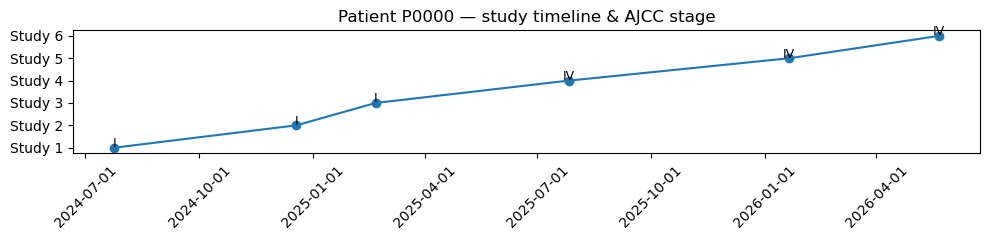

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict

# organize by patient
per_patient = defaultdict(list)
for case, dt in zip(all_cases, all_dates):
    per_patient[case.meta.patient_id].append((dt, case))

pat = sorted(per_patient.keys())[0]
timeline = sorted(per_patient[pat], key=lambda t: t)

fig, ax = plt.subplots(figsize=(10, 2.5))
dates = [dt for dt,_ in timeline]  # dt is already a datetime object
stages = [c.tnm.stage_group for _,c in timeline]
ax.plot(dates, list(range(1, len(dates)+1)), marker="o")
for d, s, idx in zip(dates, stages, range(1, len(dates)+1)):
    ax.text(d, idx+0.03, s, ha="center", fontsize=9)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
ax.set_yticks(range(1, len(dates)+1))
ax.set_yticklabels([f"Study {i}" for i in range(1, len(dates)+1)])
ax.set_title(f"Patient {pat} — study timeline & AJCC stage")
plt.tight_layout()
plt.show()